### Installing and Importing necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from opencage.geocoder import OpenCageGeocode
from time import sleep
import traceback

import seaborn as sns

print('Libraries imported.')

Libraries imported.


### Define API credentials and version

In [3]:
# The code was removed by Watson Studio for sharing.

### Getting educational institution details in San Fransisco from [web](https://data.sfgov.org/api/views/6adp-a5yv/rows.csv?accessType=DOWNLOAD).

In [7]:
edu_df = pd.read_csv('https://data.sfgov.org/api/views/6adp-a5yv/rows.csv?accessType=DOWNLOAD')
edu_df.head()

,the_geom,institutio,campus,address,webaddress,phone,st_area_sh,st_length_
0,MULTIPOLYGON (((-122.41422959861103 37.7811707...,University of California Hastings College of Law,<Null>,100 McAllister St,www.uchastings.edu,4155654600,13049.073407,492.593768
1,MULTIPOLYGON (((-122.41529196158669 37.7812009...,University of California Hastings College of Law,<Null>,198 McAllister St,www.uchastings.edu,4155654600,22642.056685,604.439178
2,MULTIPOLYGON (((-122.41701008790089 37.7813667...,University of California Hastings College of Law,<Null>,376 Larkin St,www.uchastings.edu,4155654600,25762.162205,650.066091
3,MULTIPOLYGON (((-122.41054924969892 37.8078130...,Academy of Art University,NaN,2300 Stockton St,NaN,0,37469.166147,821.907182
4,MULTIPOLYGON (((-122.41521002465295 37.8034172...,Academy of Art University,NaN,701 Chestnut St,NaN,0,10364.131930,432.953369


### Removing unnecessary columns from edu_df and adding new columns for cordinates

In [8]:
edu_df.drop(['the_geom', 'campus', 'webaddress', 'phone', 'st_area_sh', 'st_length_'], axis=1, inplace=True)
edu_df.rename(columns = {"institutio": "Institution", "address":"Address",}, inplace=True)

edu_df['Latitude'] = np.nan
edu_df['Longitude'] = np.nan
edu_df.head()

,Institution,Address,Latitude,Longitude
0,University of California Hastings College of Law,100 McAllister St,NaN,NaN
1,University of California Hastings College of Law,198 McAllister St,NaN,NaN
2,University of California Hastings College of Law,376 Larkin St,NaN,NaN
3,Academy of Art University,2300 Stockton St,NaN,NaN
4,Academy of Art University,701 Chestnut St,NaN,NaN


### Get the latitude and longitude location of the education institution addresses

In [32]:
for index in edu_df.index:
    location =  geocoder.geocode(edu_df.at[index, 'Address'] + ', San Francisco, CA, United States of America')
    if len(location)>0:
        edu_df.at[index, 'Latitude'] = location[0]['geometry']['lat']
        edu_df.at[index, 'Longitude'] = location[0]['geometry']['lng']
    sleep(1)

print("Coordinates Obtained")

Coordinates Obtained


In [10]:
edu_df.head()

,Institution,Address,Latitude,Longitude
0,University of California Hastings College of Law,100 McAllister St,37.780989,-122.413846
1,University of California Hastings College of Law,198 McAllister St,37.781438,-122.415239
2,University of California Hastings College of Law,376 Larkin St,37.781173,-122.416986
3,Academy of Art University,2300 Stockton St,37.807098,-122.410420
4,Academy of Art University,701 Chestnut St,37.803313,-122.415063


### Function to get nearby venues 

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        
        sleep(1)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting list of all venues near the educational institutions

In [12]:
edu_venues = getNearbyVenues(names=edu_df['Address'],
                                   latitudes=edu_df['Latitude'],
                                   longitudes=edu_df['Longitude']
                                  )

print(edu_venues.shape)


(3421, 8)


### Transforming venue data

In [6]:
print("Removing duplicates \n")

edu_venues.drop_duplicates(['Venue id'], keep='first', inplace=True)

print(edu_venues.shape)

Removing duplicates 

(1876, 8)


In [14]:
edu_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,100 McAllister St,37.780989,-122.413846,4f5d49a5e4b0695cbbe24694,The Strand,37.779888,-122.413138,Theater
1,100 McAllister St,37.780989,-122.413846,46d36f99f964a520594a1fe3,Orpheum Theatre,37.779315,-122.414790,Theater
2,100 McAllister St,37.780989,-122.413846,4a73812ff964a520a0dc1fe3,Alonzo King LINES Dance Center,37.780116,-122.412187,Dance Studio
3,100 McAllister St,37.780989,-122.413846,59b759e1646e387b4245f12a,Villon,37.780865,-122.412471,French Restaurant
4,100 McAllister St,37.780989,-122.413846,55da2db5498eb79ab95580cb,George and Lennie,37.781701,-122.415213,Coffee Shop


In [22]:
print("Dataset Count")
edu_venues['Venue Category'].value_counts().head(50)

Dataset Count


Coffee Shop                 102
Café                         67
Sandwich Place               41
Bar                          40
Cocktail Bar                 34
Mexican Restaurant           33
Hotel                        33
Food Truck                   32
Park                         31
Italian Restaurant           30
Sushi Restaurant             30
American Restaurant          30
Pizza Place                  29
Vietnamese Restaurant        27
Bakery                       26
Gym                          26
Gym / Fitness Center         26
Clothing Store               25
New American Restaurant      24
Art Gallery                  23
Thai Restaurant              23
Wine Bar                     22
Deli / Bodega                21
Cosmetics Shop               20
Seafood Restaurant           18
Burger Joint                 18
Breakfast Spot               18
Chinese Restaurant           17
Boutique                     17
Spa                          16
Yoga Studio                  16
Furnitur

In [23]:
print('There are {} uniques categories.'.format(len(edu_venues['Venue Category'].unique())))

There are 309 uniques categories.


### Analyzing the restaurants in the location

In [12]:
res_data = edu_venues[edu_venues['Venue Category'].str.contains('restaurant', case=False)]
print(res_data.shape)

(412, 8)


### Getting restaurant characteristics

In [13]:
def getRestaurantDetails(names, vid):
    
    restaurant_list=[]
    
    
    for name, res_id in zip(names, vid):
       
        sleep(1)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            res_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        
        # make the GET request
        try:
            result = requests.get(url).json()['response']['venue']
        except Exception:
            print(url)
            traceback.print_exc()
            continue
        
        res_pricetier = None
        res_reservations = None
        res_outdoor = None
        res_wifi = None
        res_delivery = None
        res_music = None
        res_rroom = None
        res_proom = None
        res_wheelchair = None
        res_parking = None
        
        for group in result['attributes']['groups']:
            try:
                if group['type'].lower() == 'price':
                    res_pricetier = group['items'][0]['priceTier']
                    continue
            except:
                pass
            
            try:
                if group['type'].lower() == 'reservations':
                    res_reservations = group['items'][0]['displayValue']
                    continue
            except:
                pass
            try:
                if group['type'].lower() == 'outdoorseating':
                    res_outdoor = group['items'][0]['displayValue']
                    continue
            except:
                pass
            try:
                if group['type'].lower() == 'wifi':
                    res_wifi = group['items'][0]['displayValue']
                    continue
            except:
                pass
            try:
                if group['type'].lower() == 'diningoptions':
                    res_delivery = group['items'][0]['displayValue']
                    continue
            except:
                pass
            try:
                if group['type'].lower() == 'music':
                    res_music = group['items'][0]['displayValue']
                    continue
            except:
                pass
            try:
                if group['type'].lower() == 'restroom':
                    res_rroom = group['items'][0]['displayValue']
                    continue
            except:
                pass
            try:
                if group['type'].lower() == 'privateroom':
                    res_proom = group['items'][0]['displayValue']
                    continue
            except:
                pass
            try:
                if group['type'].lower() == 'wheelchairaccessible':
                    res_wheelchair = group['items'][0]['displayValue']
                    continue
            except:
                pass
            try:
                if group['type'].lower() == 'parking':
                    if 'no' in group['summary'].lower():
                        res_parking = 'Not Avaliable'
                    else:
                        res_parking = 'Available'
                        
                    continue
            except:
                pass

        # return only relevant information for each nearby venue
        try:
            restaurant_list.append([
                name,  
                result['name'],
                result['id'],  
                result['categories'][0]['name'],
                result['likes']['count'],
                result['photos']['count'],
                result['rating'],
                result['tips']['count'],
                res_pricetier,
                res_reservations,
                res_outdoor,
                res_wifi,
                res_delivery,
                res_music,
                res_rroom,
                res_proom,
                res_wheelchair,
                res_parking])
        except:
            print(url)
            traceback.print_exc()
            continue
            
    nearby_venues = pd.DataFrame([item for item in restaurant_list])

    nearby_venues.columns = ['Neighborhood', 
            'Venue',
            'Venue id',
            'Venue Category',
            'Venue Likes',
            'Venue photos count',
            'Venue rating', 
            'Venue Tips',
            'Price Tier',
            'Reservations',
            'Outdoor',
            'Wifi',
            'Delivery',
            'Music',
            'Rest room',
            'Private room',
            'Wheel chair',
            'Parking']
        
    return(nearby_venues)

In [14]:
res_venues = getRestaurantDetails(names=res_data['Neighborhood'],
                             vid=res_data['Venue id']
                                  )

res_venues.shape

https://api.foursquare.com/v2/venues/49ca96a3f964a520c2581fe3?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 109, in getRestaurantDetails
    result['rating'],
KeyError: 'rating'


https://api.foursquare.com/v2/venues/5d79bd157e9c0f00087186b2?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 16, in getRestaurantDetails
    result = requests.get(url).json()['response']['venue']
KeyError: 'venue'


https://api.foursquare.com/v2/venues/4a05cfc3f964a52079721fe3?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 16, in getRestaurantDetails
    result = requests.get(url).json()['response']['venue']
KeyError: 'venue'


https://api.foursquare.com/v2/venues/5602fc12498ec57fde48345f?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 16, in getRestaurantDetails
    result = requests.get(url).json()['response']['venue']
KeyError: 'venue'


https://api.foursquare.com/v2/venues/4a46a5d9f964a5203da91fe3?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 16, in getRestaurantDetails
    result = requests.get(url).json()['response']['venue']
KeyError: 'venue'


https://api.foursquare.com/v2/venues/4b60a49af964a520edf129e3?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 109, in getRestaurantDetails
    result['rating'],
KeyError: 'rating'


https://api.foursquare.com/v2/venues/4a2c76dcf964a52065971fe3?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 109, in getRestaurantDetails
    result['rating'],
KeyError: 'rating'


https://api.foursquare.com/v2/venues/580307d238fa2724ad76e74a?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 109, in getRestaurantDetails
    result['rating'],
KeyError: 'rating'


https://api.foursquare.com/v2/venues/5d630e3b228cfc0008f32b4c?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 109, in getRestaurantDetails
    result['rating'],
KeyError: 'rating'


https://api.foursquare.com/v2/venues/58827c71790bea041b88fc4e?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 109, in getRestaurantDetails
    result['rating'],
KeyError: 'rating'


https://api.foursquare.com/v2/venues/5b0afb3cc824ae002ca4ffdc?client_id=HCIDLCPXVXXIOVDKBYX23CKN4ZXX41ETTQW5WZXBQRZCU20E&client_secret=1ZAJ3JJWKX44YSGEAPQIYHYRS5TCY5CII2GA43C4UC2NVB0T&v=20180605


Traceback (most recent call last):
  File "<ipython-input-13-fb989c4fc17c>", line 109, in getRestaurantDetails
    result['rating'],
KeyError: 'rating'


(401, 18)

In [16]:
res_venues.head()

,Neighborhood,Venue,Venue id,Venue Category,Venue Likes,Venue photos count,Venue rating,Venue Tips,Price Tier,Reservations,Outdoor,Wifi,Delivery,Music,Rest room,Private room,Wheel chair,Parking
0,100 McAllister St,Villon,59b759e1646e387b4245f12a,French Restaurant,119,135,8.8,14,3.0,None,No,None,Delivery,None,None,None,None,Available
1,100 McAllister St,The Flying Falafel,54c42de4498ee52a43a5ee44,Mediterranean Restaurant,271,132,8.7,58,2.0,No,Yes,None,Delivery,None,None,None,None,None
2,100 McAllister St,Morty's Delicatessen,49d66c4ef964a520c95c1fe3,American Restaurant,36,39,8.1,31,1.0,No,No,None,Delivery,None,None,None,None,None
3,100 McAllister St,Golden Era Vegan,547a3a09498edded45384099,Vegetarian / Vegan Restaurant,96,102,8.3,28,2.0,None,No,None,None,None,None,None,None,None
4,100 McAllister St,Yemen Kitchen,5633e4a5498e430fc92b4b53,Middle Eastern Restaurant,28,39,8.3,9,2.0,No,No,None,Take-out,None,None,None,None,None


In [6]:
#joining with edu_df 
res_venues = res_venues.join(edu_df.set_index('Address'), on='Neighborhood')

res_venues.head()

,Neighborhood,Venue,Venue id,Venue Category,Venue Likes,Venue photos count,Venue rating,Venue Tips,Price Tier,Reservations,...,Wifi,Delivery,Music,Rest room,Private room,Wheel chair,Parking,Institution,Latitude,Longitude
0,100 McAllister St,Villon,59b759e1646e387b4245f12a,French Restaurant,119,135,8.8,14,3.0,NaN,...,NaN,Delivery,NaN,NaN,NaN,NaN,Available,University of California Hastings College of Law,37.780989,-122.413846
1,100 McAllister St,The Flying Falafel,54c42de4498ee52a43a5ee44,Mediterranean Restaurant,271,132,8.7,58,2.0,No,...,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
2,100 McAllister St,Morty's Delicatessen,49d66c4ef964a520c95c1fe3,American Restaurant,36,39,8.1,31,1.0,No,...,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
3,100 McAllister St,Golden Era Vegan,547a3a09498edded45384099,Vegetarian / Vegan Restaurant,96,102,8.3,28,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
4,100 McAllister St,Yemen Kitchen,5633e4a5498e430fc92b4b53,Middle Eastern Restaurant,28,39,8.3,9,2.0,No,...,NaN,Take-out,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846


In [30]:
res_venues['Venue Category'].value_counts().head(15)

American Restaurant         30
Italian Restaurant          30
Mexican Restaurant          30
Sushi Restaurant            29
Vietnamese Restaurant       27
Thai Restaurant             23
New American Restaurant     23
Seafood Restaurant          18
Chinese Restaurant          16
Japanese Restaurant         14
French Restaurant           13
Restaurant                  12
Mediterranean Restaurant    12
Indian Restaurant           11
Korean Restaurant            8
Name: Venue Category, dtype: int64

### Transforming the dataframe

In [7]:
trans_res_venues = res_venues.copy()

#Dropping unnecessary columns
trans_res_venues.drop(['Neighborhood', 'Venue', 'Venue id', 'Venue Likes', 'Venue photos count', 'Venue rating', 'Venue Tips', 'Latitude', 'Longitude'], axis=1,inplace = True)

#Replacing columns with one value as No
trans_res_venues[['Rest room', 'Private room', 'Wheel chair', 'Parking']] = trans_res_venues[['Rest room', 'Private room', 'Wheel chair', 'Parking']].fillna(value = "No")

#Replace missing values with mode
trans_res_venues = trans_res_venues.apply(lambda col:col.fillna(col.value_counts().index[0]))

trans_res_venues.shape

(401, 12)

In [8]:
trans_res_venues.head()

,Venue Category,Price Tier,Reservations,Outdoor,Wifi,Delivery,Music,Rest room,Private room,Wheel chair,Parking,Institution
0,French Restaurant,3.0,No,No,Yes,Delivery,No,No,No,No,Available,University of California Hastings College of Law
1,Mediterranean Restaurant,2.0,No,Yes,Yes,Delivery,No,No,No,No,No,University of California Hastings College of Law
2,American Restaurant,1.0,No,No,Yes,Delivery,No,No,No,No,No,University of California Hastings College of Law
3,Vegetarian / Vegan Restaurant,2.0,No,No,Yes,Delivery,No,No,No,No,No,University of California Hastings College of Law
4,Middle Eastern Restaurant,2.0,No,No,Yes,Take-out,No,No,No,No,No,University of California Hastings College of Law


### Coding the categorical variables

In [13]:
#Encoding the categorical variables
trans_res_venues = trans_res_venues.apply(LabelEncoder().fit_transform)
print(trans_res_venues.shape)
trans_res_venues.head(10)


(401, 12)


,Venue Category,Price Tier,Reservations,Outdoor,Wifi,Delivery,Music,Rest room,Private room,Wheel chair,Parking,Institution
0,18,2,0,0,2,1,2,0,0,0,0,15
1,34,1,0,1,2,1,2,0,0,0,1,15
2,1,0,0,0,2,1,2,0,0,0,1,15
3,61,1,0,0,2,1,2,0,0,0,1,15
4,36,1,0,0,2,4,2,0,0,0,1,15
5,45,1,1,0,1,2,3,1,1,0,1,15
6,62,0,0,0,2,4,2,0,0,0,1,15
7,3,1,0,0,2,1,2,0,0,0,1,15
8,62,1,0,0,2,1,2,0,0,0,1,15
9,54,1,0,1,2,1,2,0,0,0,1,15


### Finding best k for cluster analysis

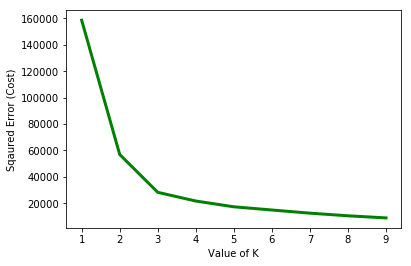

In [12]:
inertia = []

for i in range(1, 10): 
    kmeans = KMeans(n_clusters=i, random_state=0).fit(trans_res_venues) 
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

### The Squared error reduced significantly to the least when k = 3

In [4]:
# set number of clusters
kclusters = 3

In [27]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(trans_res_venues)

# check cluster labels generated for each row in the dataframe
len(kmeans.labels_) 

401

In [28]:
res_cluster = res_venues.copy()
res_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

res_cluster.to_excel('RestaurantClusters.xls', index = False)
print('Done')

res_cluster.head()

Done


,Cluster Labels,Neighborhood,Venue,Venue id,Venue Category,Venue Likes,Venue photos count,Venue rating,Venue Tips,Price Tier,Reservations,Outdoor,Wifi,Delivery,Music,Rest room,Private room,Wheel chair,Parking,Institution,Latitude,Longitude
0,0,100 McAllister St,Villon,59b759e1646e387b4245f12a,French Restaurant,119,135,8.8,14,3.0,NaN,No,NaN,Delivery,NaN,NaN,NaN,NaN,Available,University of California Hastings College of Law,37.780989,-122.413846
1,2,100 McAllister St,The Flying Falafel,54c42de4498ee52a43a5ee44,Mediterranean Restaurant,271,132,8.7,58,2.0,No,Yes,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
2,0,100 McAllister St,Morty's Delicatessen,49d66c4ef964a520c95c1fe3,American Restaurant,36,39,8.1,31,1.0,No,No,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
3,1,100 McAllister St,Golden Era Vegan,547a3a09498edded45384099,Vegetarian / Vegan Restaurant,96,102,8.3,28,2.0,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
4,2,100 McAllister St,Yemen Kitchen,5633e4a5498e430fc92b4b53,Middle Eastern Restaurant,28,39,8.3,9,2.0,No,No,NaN,Take-out,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846


### Visualize the clusters

In [42]:
# create map
sf_location =  geocoder.geocode('San Francisco, CA, United States of America')
lat = sf_location[0]['geometry']['lat']
lng =  sf_location[0]['geometry']['lng']

print('Latitude: ' + str(lat) + ' and ' + 'Longitude: ' + str(lng))

Latitude: 37.7790262 and Longitude: -122.4199061


In [5]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

map_clusters = folium.Map(location=[lat, lng], zoom_start=12, attr='<a href=/>No Link</a>')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [6]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(res_cluster['Latitude'], res_cluster['Longitude'], res_cluster['Neighborhood'], res_cluster['Cluster Labels']):
    label = folium.Popup(html=str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analysing the clusters

In [30]:
first_cluster = res_cluster.loc[res_cluster['Cluster Labels'] == 0]
second_cluster = res_cluster.loc[res_cluster['Cluster Labels'] == 1]
third_cluster = res_cluster.loc[res_cluster['Cluster Labels'] == 2]

### Cluster 1:

In [31]:
first_cluster.head()

,Cluster Labels,Neighborhood,Venue,Venue id,Venue Category,Venue Likes,Venue photos count,Venue rating,Venue Tips,Price Tier,Reservations,Outdoor,Wifi,Delivery,Music,Rest room,Private room,Wheel chair,Parking,Institution,Latitude,Longitude
0,0,100 McAllister St,Villon,59b759e1646e387b4245f12a,French Restaurant,119,135,8.8,14,3.0,NaN,No,NaN,Delivery,NaN,NaN,NaN,NaN,Available,University of California Hastings College of Law,37.780989,-122.413846
2,0,100 McAllister St,Morty's Delicatessen,49d66c4ef964a520c95c1fe3,American Restaurant,36,39,8.1,31,1.0,No,No,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
7,0,100 McAllister St,Sunday at the Museum,5ac91da5c5309357e35b5e75,Asian Restaurant,30,41,7.7,5,2.0,No,No,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
12,0,100 McAllister St,Tadu Ethiopian Kitchen,54c16037498e2e5544db41d1,Ethiopian Restaurant,94,69,8.4,22,2.0,No,No,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
18,0,100 McAllister St,homeskillet,5351e136498e38b9d504db86,American Restaurant,151,118,7.6,34,2.0,No,No,Yes,No Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846


### Cluster 2:

In [32]:
second_cluster.head()

,Cluster Labels,Neighborhood,Venue,Venue id,Venue Category,Venue Likes,Venue photos count,Venue rating,Venue Tips,Price Tier,Reservations,Outdoor,Wifi,Delivery,Music,Rest room,Private room,Wheel chair,Parking,Institution,Latitude,Longitude
3,1,100 McAllister St,Golden Era Vegan,547a3a09498edded45384099,Vegetarian / Vegan Restaurant,96,102,8.3,28,2.0,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
5,1,100 McAllister St,Birdsong,5ae925e7c0f163002cc57349,Restaurant,61,92,9.1,8,2.0,Yes,No,No,No Delivery,Yes,Yes,Yes,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
6,1,100 McAllister St,Tú Lan Restaurant,41799f00f964a520c11d1fe3,Vietnamese Restaurant,316,351,8.5,144,1.0,NaN,No,NaN,Take-out,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
8,1,100 McAllister St,Mộng Thu,4cdf14a1ffcf3704523e1782,Vietnamese Restaurant,18,37,7.9,7,2.0,NaN,No,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
9,1,100 McAllister St,Elephant Sushi,530eab1b498e43184817a4fc,Sushi Restaurant,13,30,7.7,1,2.0,No,Yes,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846


### Cluster 3:

In [33]:
third_cluster.head()

,Cluster Labels,Neighborhood,Venue,Venue id,Venue Category,Venue Likes,Venue photos count,Venue rating,Venue Tips,Price Tier,Reservations,Outdoor,Wifi,Delivery,Music,Rest room,Private room,Wheel chair,Parking,Institution,Latitude,Longitude
1,2,100 McAllister St,The Flying Falafel,54c42de4498ee52a43a5ee44,Mediterranean Restaurant,271,132,8.7,58,2.0,No,Yes,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
4,2,100 McAllister St,Yemen Kitchen,5633e4a5498e430fc92b4b53,Middle Eastern Restaurant,28,39,8.3,9,2.0,No,No,NaN,Take-out,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
15,2,100 McAllister St,Gyro King,44e36f32f964a52041371fe3,Mediterranean Restaurant,46,64,7.5,38,2.0,No,No,NaN,Delivery,NaN,NaN,NaN,NaN,NaN,University of California Hastings College of Law,37.780989,-122.413846
20,2,100 McAllister St,El Castillito,51b28827498ef0351235c618,Mexican Restaurant,10,6,7.1,2,1.0,No,No,NaN,Delivery,NaN,Yes,NaN,Yes,NaN,University of California Hastings College of Law,37.780989,-122.413846
25,2,100 McAllister St,Jin Mi Korean Cuisine,52c1ec13498e768ed96c0fdf,Korean Restaurant,73,85,7.1,25,1.0,No,No,NaN,Take-out,NaN,Yes,NaN,Yes,NaN,University of California Hastings College of Law,37.780989,-122.413846


### Descriptive statistics

### Mean of each cluster

In [34]:
res_cluster.groupby("Cluster Labels").mean()

,Venue Likes,Venue photos count,Venue rating,Venue Tips,Price Tier,Latitude,Longitude
Cluster Labels,,,,,,,
0,183.050505,260.010101,7.959596,59.919192,2.239583,37.782092,-122.411670
1,182.896552,250.075862,8.053793,64.310345,2.087591,37.784501,-122.413086
2,220.847134,225.668790,8.066242,71.808917,2.198675,37.780841,-122.411148


## Getting the venue categories that are unique in each cluster and which are in a average number

In [49]:
vc_temp = []

for cluster_label, cluster_df in res_cluster.groupby("Cluster Labels"):    
    for item in cluster_df["Venue Category"].value_counts(normalize=False).iteritems():
            vc_temp.append([cluster_label, item[0], item[1]])

categories_vcount = pd.DataFrame([item for item in vc_temp])

categories_vcount.columns = ['Cluster', 'Value', 'Count']

categories_vcount.drop_duplicates(subset ="Value", 
                     keep = False, inplace = True)

categories_vcount[(categories_vcount['Count'] >5) & (categories_vcount['Count'] < 15)]

,Cluster,Value,Count
2,0,French Restaurant,14
3,0,Asian Restaurant,7
24,1,Restaurant,12
25,1,Ramen Restaurant,7
26,1,Vegetarian / Vegan Restaurant,6
43,2,Japanese Restaurant,13
44,2,Mediterranean Restaurant,12
45,2,Indian Restaurant,11
46,2,Korean Restaurant,8
47,2,Latin American Restaurant,6


### Saving value counts of each cluster in a dataframe

In [35]:
vc_temp = []

columns = ['Venue Category', 'Reservations', 'Outdoor', 'Wifi', 'Delivery', 'Music', 'Rest room',
       'Private room', 'Wheel chair', 'Parking', 'Institution']

for cluster_label, cluster_df in res_cluster.groupby("Cluster Labels"):
    for column in columns:
        for item in cluster_df[column].value_counts(normalize=False).iteritems():
            key = item[0]
            value = item[1]
            vc_temp.append([cluster_label, column, item[0], item[1]])
        
        
venues_vcount = pd.DataFrame([item for item in vc_temp])

venues_vcount.columns = ['Cluster', 'Column Name', 'Value', 'Count']

venues_vcount.head()

,Cluster,Column Name,Value,Count
0,0,Venue Category,American Restaurant,30
1,0,Venue Category,Chinese Restaurant,15
2,0,Venue Category,French Restaurant,14
3,0,Venue Category,Asian Restaurant,7
4,0,Venue Category,Brazilian Restaurant,4


### Finding the top three locations in each cluster

In [55]:
for cluster_label, cluster_df in res_cluster.groupby("Cluster Labels"):
    print(cluster_label)
    print(cluster_df["Neighborhood"].value_counts().head(3))

0
100 McAllister St      8
410 Bush St            7
350 Rhode Island St    7
Name: Neighborhood, dtype: int64
1
100 McAllister St     18
415 Jackson St        12
1849 Washington St    11
Name: Neighborhood, dtype: int64
2
1125 Valencia St    18
415 Jackson St      13
30 Grant Ave        11
Name: Neighborhood, dtype: int64


### Visualizing the Data

### Visualizing the statistics of top 10 neighborhoods

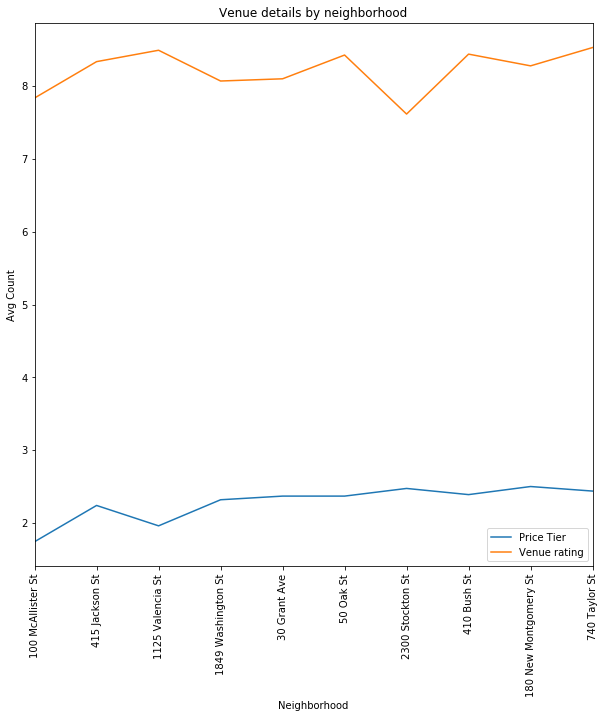

In [36]:
freq_neighborhood = res_venues["Neighborhood"].value_counts().head(10)

neighbourhood_stats = res_venues.groupby("Neighborhood").mean().drop(['Latitude', 'Longitude'], axis=1)
neighbourhood_stats.loc[[index for index in freq_neighborhood.index],['Price Tier', 'Venue rating']].plot(kind='line', figsize=(10, 10))

plt.title('Venue details by neighborhood')
plt.ylabel('Avg Count')
plt.xlabel('Neighborhood')
plt.xticks(rotation='vertical')
plt.show()

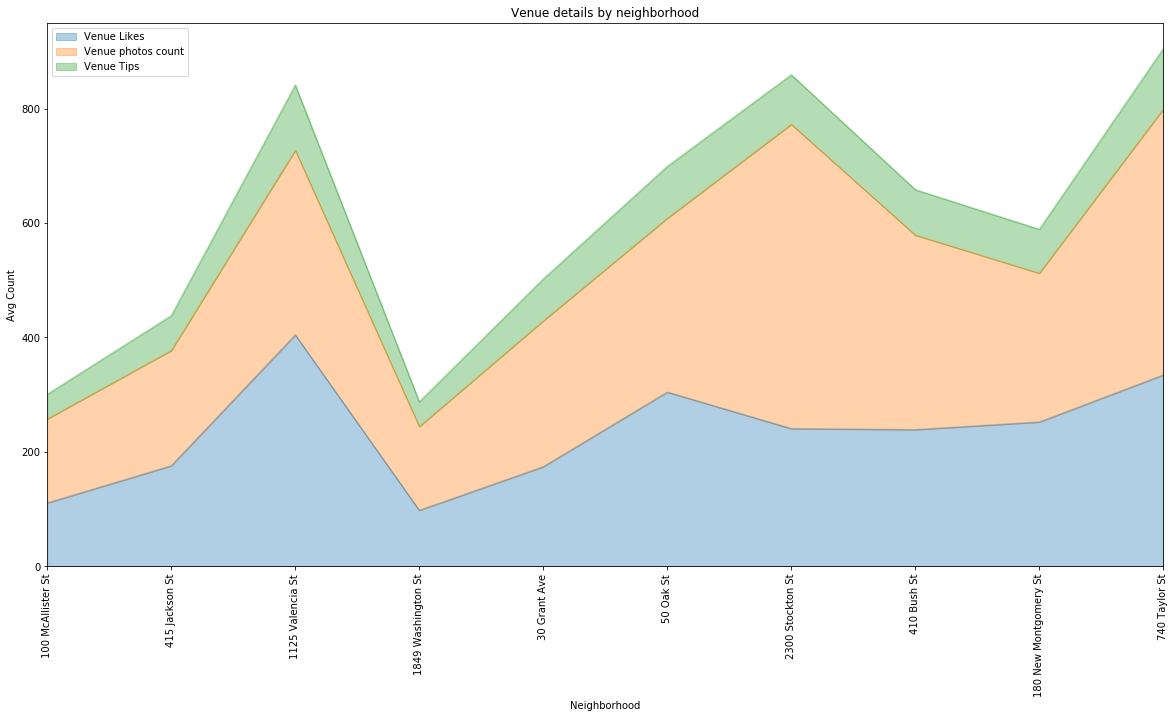

In [37]:
neighbourhood_stats.drop(['Price Tier', 'Venue rating'], axis=1).loc[[index for index in freq_neighborhood.index]].plot(kind='area', alpha=0.35, figsize=(20, 10))

plt.title('Venue details by neighborhood')
plt.ylabel('Avg Count')
plt.xlabel('Neighborhood')
plt.xticks(rotation='vertical')
plt.show()

### Visualizing the characteristics of each cluster

### Reservations by cluster

Text(0.5,1,'Reservations by cluster')

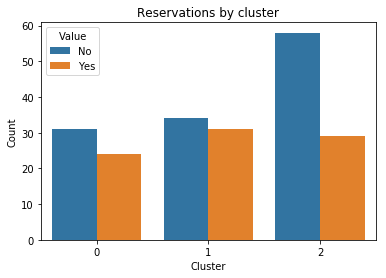

In [38]:
sns.barplot(x='Cluster', y='Count', hue ='Value', data=venues_vcount[venues_vcount['Column Name'] == 'Reservations'].drop('Column Name', axis=1)).set_title('Reservations by cluster')

### Outdoor Seating availability by cluster

Text(0.5,1,'Outdoor Seating availability by cluster')

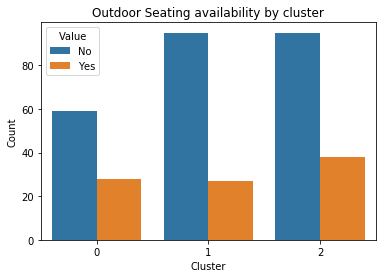

In [39]:
sns.barplot(x='Cluster', y='Count', hue ='Value', data=venues_vcount[venues_vcount['Column Name'] == 'Outdoor'].drop('Column Name', axis=1)).set_title('Outdoor Seating availability by cluster')

### Wi-fi availablity by cluster

Text(0.5,1,'Wi-fi availablity by cluster')

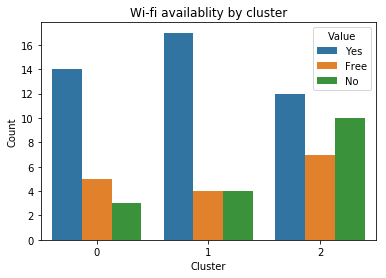

In [40]:
sns.barplot(x='Cluster', y='Count', hue ='Value', data=venues_vcount[venues_vcount['Column Name'] == 'Wifi'].drop('Column Name', axis=1)).set_title('Wi-fi availablity by cluster')

### Delivery option availablity by cluster

Text(0.5,1,'Delivery option availablity by cluster')

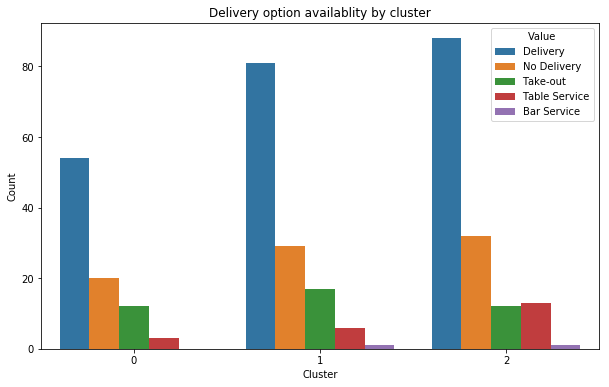

In [41]:

fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='Cluster', y='Count', hue='Value', ax =ax, data=venues_vcount[venues_vcount['Column Name'] == 'Delivery'].drop('Column Name', axis=1)).set_title('Delivery option availablity by cluster')

### Music availablity by cluster

Text(0.5,1,'Music availablity by cluster')

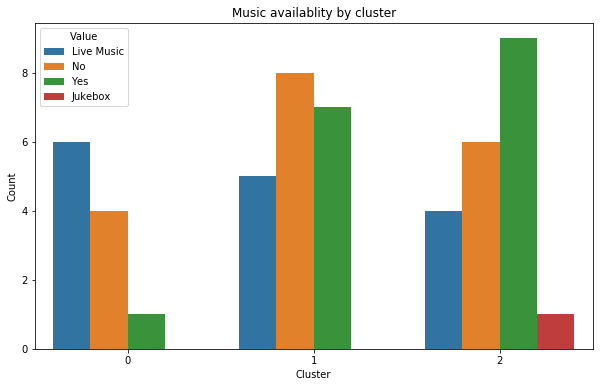

In [42]:
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='Cluster', y='Count', hue ='Value', ax=ax, data=venues_vcount[venues_vcount['Column Name'] == 'Music'].drop('Column Name', axis=1)).set_title('Music availablity by cluster')

### Facilities availablity by cluster

Text(0.5,1,'Facilities availablity by cluster')

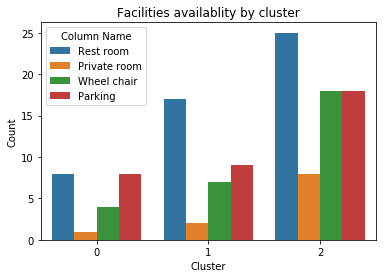

In [56]:
fac_sing = venues_vcount[(venues_vcount['Column Name'] == 'Rest room')|(venues_vcount['Column Name'] == 'Private room')|\
                        (venues_vcount['Column Name'] == 'Wheel chair')|(venues_vcount['Column Name'] == 'Parking')]
fac_sing = fac_sing.replace('Available', 'Yes')

sns.barplot(x='Cluster', y='Count', hue ='Column Name', data=fac_sing).set_title('Facilities availablity by cluster')

### Top venue categories in each cluster

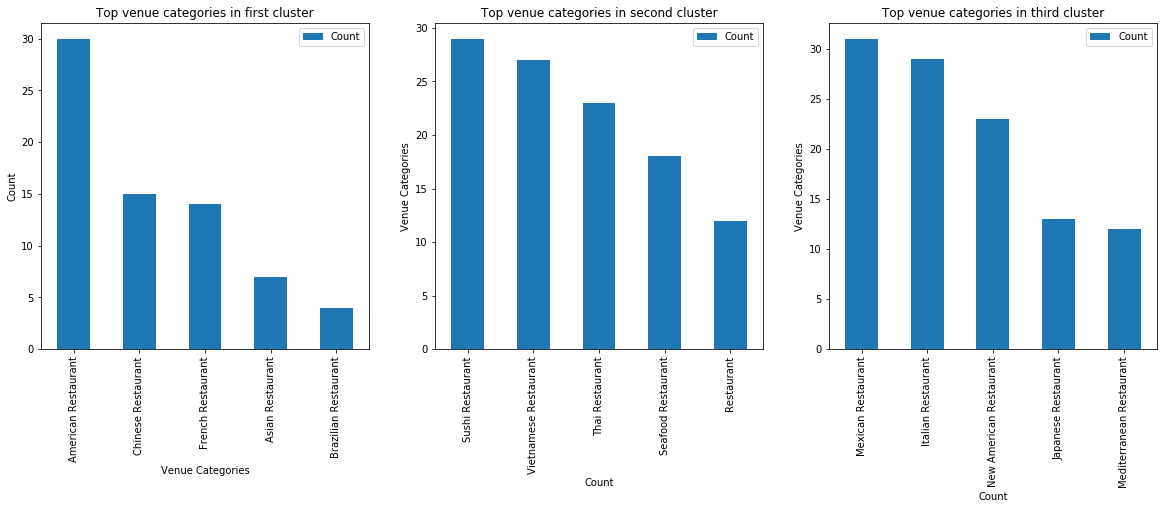

In [57]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(1, 3, 3)

# Subplot 1: Box plot

venues_vcount[(venues_vcount['Cluster'] == 0) & (venues_vcount['Column Name'] == 'Venue Category')]\
.drop(['Column Name', 'Cluster'], axis=1).set_index('Value').head(5).plot(kind='bar', figsize=(20, 6), ax=ax0)
ax0.set_title('Top venue categories in first cluster')
ax0.set_xlabel('Venue Categories')
ax0.set_ylabel('Count')

# Subplot 2: Line plot
venues_vcount[(venues_vcount['Cluster'] == 1) & (venues_vcount['Column Name'] == 'Venue Category')]\
.drop(['Column Name', 'Cluster'], axis=1).set_index('Value').head(5).plot(kind='bar', figsize=(20, 6), ax=ax1)
ax1.set_title ('Top venue categories in second cluster')
ax1.set_ylabel('Venue Categories')
ax1.set_xlabel('Count')

# Subplot 3: Line plot
venues_vcount[(venues_vcount['Cluster'] == 2) & (venues_vcount['Column Name'] == 'Venue Category')]\
.drop(['Column Name', 'Cluster'], axis=1).set_index('Value').head(5).plot(kind='bar', figsize=(20, 6), ax=ax2)
ax2.set_title ('Top venue categories in third cluster')
ax2.set_ylabel('Venue Categories')
ax2.set_xlabel('Count')

plt.show()

### Top institutions in each cluster

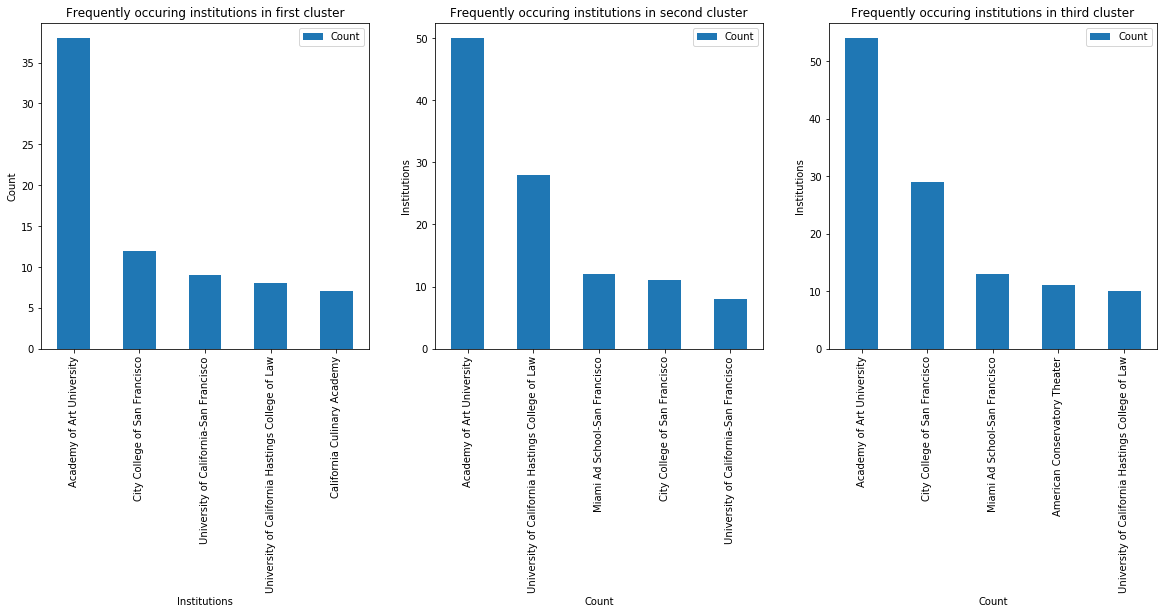

In [59]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(1, 3, 3)

# Subplot 1: Box plot

venues_vcount[(venues_vcount['Cluster'] == 0) & (venues_vcount['Column Name'] == 'Institution')]\
.drop(['Column Name', 'Cluster'], axis=1).set_index('Value').head(5).plot(kind='bar', figsize=(20, 6), ax=ax0)
ax0.set_title('Frequently occuring institutions in first cluster')
ax0.set_xlabel('Institutions')
ax0.set_ylabel('Count')

# Subplot 2: Line plot
venues_vcount[(venues_vcount['Cluster'] == 1) & (venues_vcount['Column Name'] == 'Institution')]\
.drop(['Column Name', 'Cluster'], axis=1).set_index('Value').head(5).plot(kind='bar', figsize=(20, 6), ax=ax1)
ax1.set_title ('Frequently occuring institutions in second cluster')
ax1.set_ylabel('Institutions')
ax1.set_xlabel('Count')

# Subplot 3: Line plot
venues_vcount[(venues_vcount['Cluster'] == 2) & (venues_vcount['Column Name'] == 'Institution')]\
.drop(['Column Name', 'Cluster'], axis=1).set_index('Value').head(5).plot(kind='bar', figsize=(20, 6), ax=ax2)
ax2.set_title ('Frequently occuring institutions in third cluster')
ax2.set_ylabel('Institutions')
ax2.set_xlabel('Count')

plt.show()